In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from thermography_dataset import ThermDataset
%matplotlib inline

## Parameters 
Spec to Temp
Loss: 15
- batch size = 32
- epochs = 5000
- layers = lin2(60), lin3(45)
- lr = 0.01
- noise scale = 0.01
- test size = 30%

Temp to Spec
Loss: 0.0233

# Prepare Data

In [69]:
direction = 1
noise = 0.001

In [70]:
dataset = ThermDataset(fp='combined_data.xlsx', direction=direction, noise_scale=noise)

In [71]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [72]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=32)

# Design Model 
(input size, output size, forward pass)

In [73]:
class ForwardNet(nn.Module):
    def __init__(self, middle_size, io_size):
        super(ForwardNet, self).__init__()
        self.lin1 = nn.Linear(middle_size, 60)
        self.lin2 = nn.Linear(60, 60)
        self.lin3 = nn.Linear(60, 30)
        self.lin_fin = nn.Linear(30, io_size)


    def forward(self, X_batch):
        output = F.leaky_relu(self.lin1(X_batch))
        output = F.leaky_relu(self.lin2(output))
        output = F.leaky_relu(self.lin3(output))
        output = self.lin_fin(output)
        return output

In [74]:
class InverseNet(nn.Module):
    def __init__(self, io_size, middle_size):
        super(InverseNet, self).__init__()
        self.lin1 = nn.Linear(io_size, 30)
        self.lin2 = nn.Linear(30, 60)
        self.lin3 = nn.Linear(60, 60)
        self.lin_fin = nn.Linear(60, middle_size)

    def forward(self, y_batch):
        output = F.leaky_relu(self.lin1(y_batch))
        output = F.leaky_relu(self.lin2(output))
        output = F.leaky_relu(self.lin3(output))
        output = self.lin_fin(output)
        return output

In [75]:
class TandemNet(nn.Module):
    def __init__(self, forward_model, inverse_model):
        super(TandemNet, self).__init__()
        self.forward_model = forward_model
        self.inverse_model = inverse_model

    def forward(self, y):
        pred_temp = self.inverse_model(y)
        pred_spec = self.forward_model(pred_temp)
        return pred_temp, pred_spec

In [76]:
n_samples = len(train_dataset)
_, middle_size = dataset.x.shape
_, io_size = dataset.y.shape

# define variables for each model
forward_model = ForwardNet(middle_size, io_size)
inverse_model = InverseNet(io_size, middle_size)
tandem_net = TandemNet(forward_model, inverse_model)

# Construct Loss and Optimizer

In [77]:
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer_forward = torch.optim.Rprop(forward_model.parameters(), lr=learning_rate)
optimizer_tandem = torch.optim.Rprop(inverse_model.parameters(), lr=learning_rate)

# Training Loop

In [78]:
def train_forward_model(forward_model, train_loader):

    forward_loss_list = []
    num_forward_epochs = 1000
    best_forward_loss = np.inf
    best_forward_epoch = 0

    for epoch in range(num_forward_epochs):
        for X_batch, y_batch in train_loader:
            # forward pass and loss
            y_pred = forward_model(X_batch)
            loss = criterion(y_pred, y_batch)

            # backward pass
            loss.backward()

            # update
            optimizer_forward.step()

            # empty gradients
            optimizer_forward.zero_grad()
        
        forward_loss_list.append(loss.item())
        
        if loss < best_forward_loss:
            best_forward_loss = loss
            best_forward_epoch = epoch+1

        if (epoch+1) % int(num_forward_epochs/10) == 0:
            print(f'forward epoch: {epoch+1}, forward loss = {loss}')

    print(f'\nbest forward loss: {best_forward_loss:.2f} in forward epoch: {best_forward_epoch}')
    return num_forward_epochs, forward_loss_list

In [79]:
def train_tandem_model(inverse_model, forward_model, train_loader):

    tandem_loss_list = []
    inverse_loss_list = []
    num_inverse_epochs = 1000
    best_inverse_loss = np.inf
    best_inverse_epoch = 0

    for epoch in range(num_inverse_epochs):
        for X_batch, y_batch in train_loader:
            # forward pass through both models
            X_pred = inverse_model(y_batch)
            y_pred = forward_model(X_pred)

            # calculate tandem loss (used for training)
            tandem_loss = criterion(y_pred, y_batch)

            # calculate the inverse loss (what we care about but not used for training)
            inverse_loss = criterion(X_pred, X_batch)

            # backward pass
            tandem_loss.backward()

            # update
            optimizer_tandem.step()

            # empty gradients
            optimizer_tandem.zero_grad()
        
        tandem_loss_list.append(tandem_loss.item())
        inverse_loss_list.append(inverse_loss.item())
        
        if inverse_loss < best_inverse_loss:
            best_inverse_loss = inverse_loss
            best_inverse_epoch = epoch+1

        if (epoch+1) % int(num_inverse_epochs/10) == 0:
            print(f'tandem epoch: {epoch+1}, tandem loss = {tandem_loss:.4f}, *INVERSE LOSS* = {inverse_loss:.4f}')

    print(f'\n best inverse loss: {best_inverse_loss:.2f} in inverse epoch: {best_inverse_epoch}')
    return num_inverse_epochs, inverse_loss_list, tandem_loss_list

In [80]:
# first train the forward model, then the tandem
num_forward_epochs, forward_loss_list = train_forward_model(forward_model, train_loader)
num_inverse_epochs, inverse_loss_list, tandem_loss_list = train_tandem_model(inverse_model, forward_model, train_loader)

forward epoch: 100, forward loss = 0.0000
forward epoch: 200, forward loss = 0.0000
forward epoch: 300, forward loss = 0.0000
forward epoch: 400, forward loss = 0.0000
forward epoch: 500, forward loss = 0.0000
forward epoch: 600, forward loss = 0.0000
forward epoch: 700, forward loss = 0.0000
forward epoch: 800, forward loss = 0.0000
forward epoch: 900, forward loss = 0.0000
forward epoch: 1000, forward loss = 0.0000

best forward loss: 0.00 in forward epoch: 992
tandem epoch: 100, tandem loss = 0.0000, *INVERSE LOSS* = 0.9320
tandem epoch: 200, tandem loss = 0.0000, *INVERSE LOSS* = 1.7300
tandem epoch: 300, tandem loss = 0.0000, *INVERSE LOSS* = 1.3294
tandem epoch: 400, tandem loss = 0.0000, *INVERSE LOSS* = 0.9918
tandem epoch: 500, tandem loss = 0.0000, *INVERSE LOSS* = 0.7741
tandem epoch: 600, tandem loss = 0.0000, *INVERSE LOSS* = 0.9245
tandem epoch: 700, tandem loss = 0.0000, *INVERSE LOSS* = 1.1199
tandem epoch: 800, tandem loss = 0.0000, *INVERSE LOSS* = 1.0521
tandem epoch

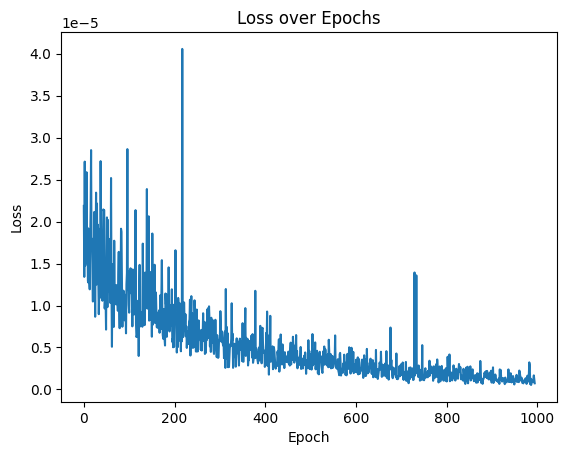

In [81]:
plt.plot(forward_loss_list[5:])

plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Testing

In [82]:
import matplotlib.pyplot as plt

def plot_actual_vs_pred(pred, actual, index):
    actual_np = actual[index]
    pred_np = pred[index]


    plt.plot(actual_np, label='actual')
    plt.plot(pred_np, 'r+', label='predicted')

    if not direction:
        plt.title("Temperature to Spectra")
        plt.xlabel("Wavlength")
        plt.ylabel("Intensity")
    else:
        plt.title("Spectra to Temperature")
        plt.xlabel("Silica Layer")
        plt.ylabel("Temperature (K)")

    plt.legend()
    plt.show()

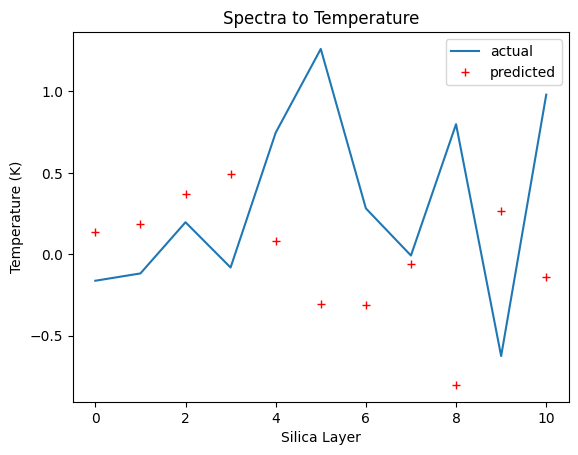

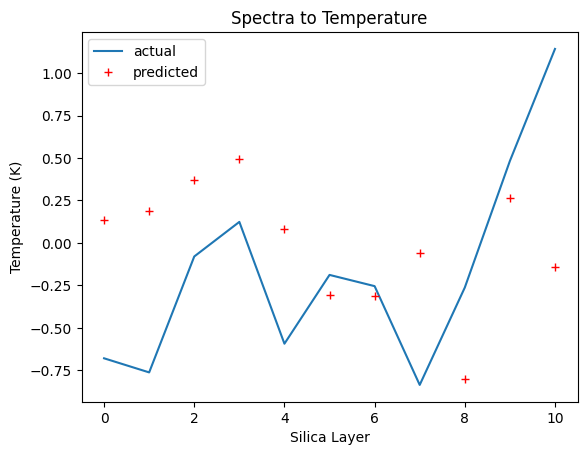

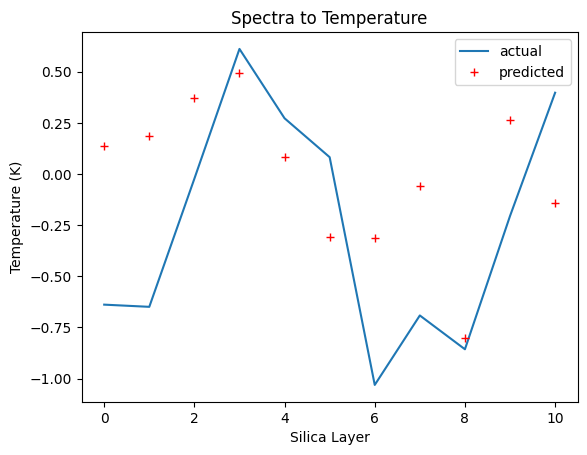

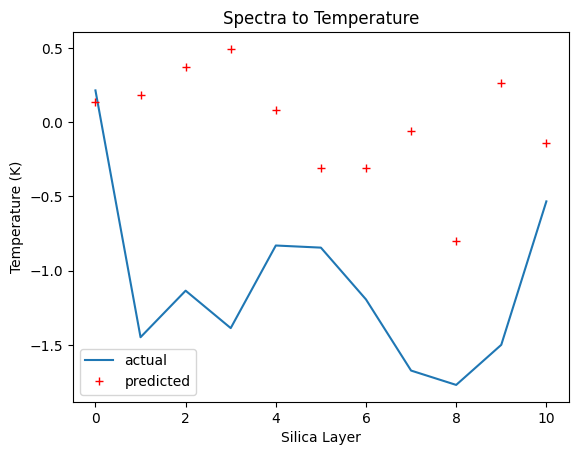

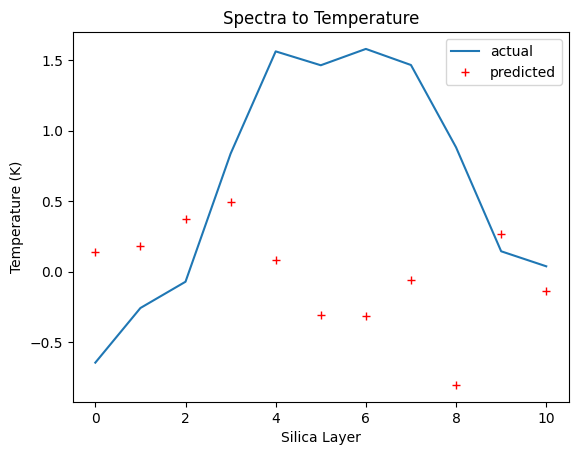

average loss: 1.1367353143114032


In [83]:
total_loss = 0
n_samples = 0
total_batches = len(test_loader)
current_batch = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        actual_input = y_batch
        actual_middle = X_batch

        pred_middle = inverse_model(actual_input)
        inverse_test_loss = criterion(pred_middle, actual_middle)
        total_loss += inverse_test_loss.item() * len(X_batch)
        n_samples += len(X_batch)
        current_batch += 1

        if current_batch % int(total_batches/5) == 0:
            plot_actual_vs_pred(pred_middle.numpy(), actual_middle.numpy(), 0) 

average_loss = total_loss/n_samples
print(f"average loss: {average_loss}")